# HW2.1 Illumina read analysis

In [160]:
import pysam
import seaborn as sns
import numpy as np
import pandas as pd

from collections import Counter

### Part 0. Index, allign, flagstat

In [199]:
reference_path = 'data/B_faecium/ref.fasta.gz'
jump_1 = 'data/B_faecium/jump.R1.fastq.gz'
jump_2 = 'data/B_faecium/jump.R2.fastq.gz'
frag_1 = 'data/B_faecium/frag.R1.fastq.gz'
frag_2 = 'data/B_faecium/frag.R2.fastq.gz'
jump_alignment = 'data/B_faecium/jump_alignment_sorted.bam'
frag_alignment = 'data/B_faecium/frag_alignment_sorted.bam'

In [143]:
!bwa index ./data/B_faecium/ref.fasta.gz

[bwa_index] Pack FASTA... 0.04 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.02 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward-only FASTA... 0.03 sec
[bwa_index] Construct SA from BWT and Occ... 0.26 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index ./data/B_faecium/ref.fasta.gz
[main] Real time: 1.402 sec; CPU: 1.393 sec


In [ ]:
!bwa mem ./data/B_faecium/ref.fasta.gz ./data/B_faecium/frag.R1.fastq.gz ./data/B_faecium/frag.R2.fastq.gz > ./data/B_faecium/frag_alignment.sam

In [195]:
!samtools view -S -b ./data/B_faecium/frag_alignment.sam > ./data/B_faecium/frag_alignment.bam

In [196]:
!samtools flagstat ./data/B_faecium/frag_alignment.bam

3432529 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
165 + 0 supplementary
0 + 0 duplicates
3424657 + 0 mapped (99.77% : N/A)
3432364 + 0 paired in sequencing
1716182 + 0 read1
1716182 + 0 read2
3407384 + 0 properly paired (99.27% : N/A)
3416620 + 0 with itself and mate mapped
7872 + 0 singletons (0.23% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [197]:
!samtools sort ./data/B_faecium/frag_alignment.bam  -o ./data/B_faecium/frag_alignment_sorted.bam 

[bam_sort_core] merging from 1 files and 1 in-memory blocks...


In [198]:
!samtools index ./data/B_faecium/frag_alignment_sorted.bam

### Part 1. Genome coverage

#### B_faecium/frag.R1.fastq.gz B_faecium/frag.R2.fastq.gz

In [202]:
frag_bam = pysam.AlignmentFile(frag_alignment, "rb")

In [203]:
headers = frag_bam.references
print(headers)

('Contig184',)


In [210]:
def calculate_coverage(bamfile, contig, segment_lenght=5000):
    total_cov = []
    current_cov = 0
    prev_pos = 0
    skipped = 1
    
    for pile in bamfile.pileup(contig):
        current_pos = pile.pos
        if prev_pos + 1 != current_pos:
            skipped += current_pos - prev_pos - 1
        if current_pos // segment_lenght > prev_pos // segment_lenght:
            total_cov.append(current_cov / segment_lenght)
            current_cov = 0
        current_cov += pile.n
        prev_pos = current_pos
    coverage_frac = 1 - skipped / bamfile.lengths[0]
    return total_cov, coverage_frac * 100

Доля покрытия: 100.0 %.


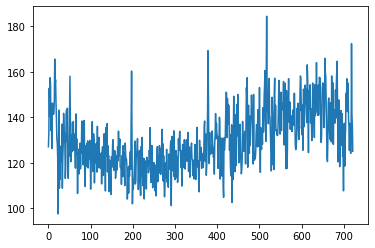

In [211]:
total_cov, coverage_percent = calculate_coverage(frag_bam, 'Contig184')
print(f'Доля покрытия: {coverage_percent} %.')
sns.lineplot(x=range(len(total_cov)), y=total_cov)

#### B_faecium/jump.R1.fastq.gz B_faecium/jumo.R2.fastq.gz

In [212]:
jump_bam = pysam.AlignmentFile(jump_alignment, "rb")

In [213]:
headers = jump_bam.references
print(headers)

('Contig184',)


Доля покрытия: 83.13 %.


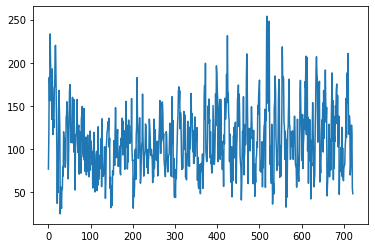

In [215]:
total_cov, coverage_percent = calculate_coverage(jump_bam, 'Contig184')
print(f'Доля покрытия: {coverage_percent:.2f} %.')
sns.lineplot(x=range(len(total_cov)), y=total_cov)

## Part 2. Distribution of insertion length.

#### B_faecium/frag.R1.fastq.gz B_faecium/frag.R2.fastq.gz

In [217]:
template_lengths = [read.template_length for read in frag_bam.fetch('Contig184') if read.template_length > 0]
c = Counter(template_lengths)

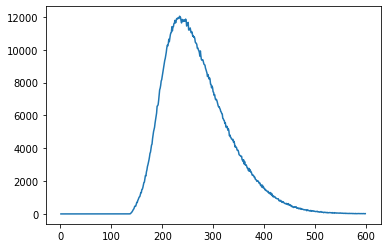

In [222]:
l = list(range(1, 600))
a = [c[x] for x in l]
sns.lineplot(x = l, y = a)

In [223]:
def print_stats(array):
    t = np.array(array)
    print(f'Среднее расстояние вставки: {t.mean():.2f}.')
    print(f'Среднеквадротичное отклонение: {t.std():.2f}.')
    print(f'Интервал минимальной ширины для 95% ридов: {np.quantile(t, 0.95):.2f}.')
        

In [225]:
print_stats(template_lengths)

Среднее расстояние вставки: 2372.56.
Среднеквадротичное отклонение: 63457.56.
Интервал минимальной ширины для 95% ридов: 393.00.


#### B_faecium/jump.R1.fastq.gz B_faecium/jump.R2.fastq.gz

In [226]:
template_lengths = [read.template_length for read in jump_bam.fetch('Contig184') if read.template_length > 0]
c = Counter(template_lengths)

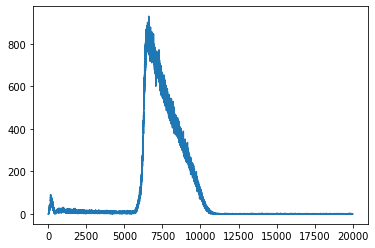

In [227]:
l = list(range(1, 20000))
a = [c[x] for x in l]
sns.lineplot(x = l, y = a)

In [228]:
print_stats(template_lengths)

Среднее расстояние вставки: 125215.30.
Среднеквадротичное отклонение: 463798.29.
Интервал минимальной ширины для 95% ридов: 1000706.25.


## Part 3.

In [229]:
!samtools faidx ./data/B_faecium/ref.fasta.gz

In [233]:
def build_substitution_matrix(bamfile, contig, reference_path):
    substitution_matrix = pd.DataFrame(
        {'A': [0,0,0,0], 'C': [0,0,0,0], 'G': [0,0,0,0], 'T': [0,0,0,0]}, 
        index=['A', 'C', 'G', 'T']
    )
    ref_fasta = pysam.FastaFile(reference_path)
    seq = ref_fasta.fetch(contig)
    ref_gen = enumerate(seq)
    pos, base = next(ref_gen)

    for pileupcolumn in bamfile.pileup(contig):
        while pos != pileupcolumn.reference_pos:
            pos, base = next(ref_gen)
        q_seq = pileupcolumn.get_query_sequences()
        for nucleotide in q_seq:
            ncl = nucleotide.upper()
            if ncl != base and ncl != 'N':
                substitution_matrix.at[base, ncl] += 1
    return substitution_matrix

#### B_faecium/frag.R1.fastq.gz B_faecium/frag.R2.fastq.gz

In [234]:
frag_mtrx = build_substitution_matrix(frag_bam, 'Contig184', reference_path)

In [235]:
print('Матрица замен для frag.R*')
print(frag_mtrx)

Матрица замен для frag.R*
        A       C       G       T
A       0  934671  504977   67986
C  397497       0  680972  149111
G  155718  715835       0  350429
T   77555  545981  930329       0


#### B_faecium/jump.R1.fastq.gz B_faecium/jump.R2.fastq.gz

In [236]:
jump_mtrx = build_substitution_matrix(jump_bam, 'Contig184', reference_path)
print('Матрица замен для jump.R*')
print(jump_mtrx)

Матрица замен для jump.R*
        A       C       G       T
A       0  774816  457471   39056
C  128229       0  432730   66434
G   65775  426529       0  128910
T   39099  448806  786418       0
